# INITIAL SETUP

In [225]:
import pandas as pd
import os
import numpy as np
import seaborn as sns                      
import matplotlib.pyplot as plt
from datetime import datetime as dt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score,f1_score,precision_score,recall_score
            
%matplotlib inline     
sns.set(color_codes=True)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)
data = pd.read_csv("../data/cleaned/FIFA_players_21_cleaned.csv")

# DATA PREPROCESSING

Copying and changing columns to minimalize skewness. Also deleting unnecessary columns

In [226]:
df = data.copy()
cols_to_log = ['wage_eur_year_m', 'value_eur_m', 'release_clause_eur_m']
for col in cols_to_log:
    df[col] = np.log1p(df[col])
df.drop(["sofifa_id","player_url","short_name","long_name","dob","joined","club_name","league_name","player_positions","nationality","release_clause_eur_m","wage_eur_year_m","overall","potential","movement_reactions","skill_ball_control"],axis=1,inplace=True)

Encodding with label and one hot

In [227]:
def encoder(df, col):
    if df[col].dtype == 'object':
        n_unique = df[col].nunique()
        
        if n_unique <= 2:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])
            return df
        
        elif 2 < n_unique <= 10:
            ohe = OneHotEncoder()
            ohe_df = pd.DataFrame(ohe.fit_transform(df[[col]]).toarray())
            ohe_df.columns = [col + "_" + str(i) for i in ohe_df.columns]
            df = df.drop(col, axis=1).join(ohe_df)
            return df
        else:
            return df
            
    else:
        return df
       
for i in df.columns:
    df = encoder(df, i)

Saving csv file that is used for training models

In [228]:
output_dir = "C:/Users/cozid/OneDrive/Desktop/data-science-internship/data/cleaned"  
filename = "fifa_players_21_model.csv"
output_path = os.path.join(output_dir, filename)

df.to_csv(output_path, index=False)
print(f"File saved to: {output_path}")

File saved to: C:/Users/cozid/OneDrive/Desktop/data-science-internship/data/cleaned\fifa_players_21_model.csv


X, Y split and training split

In [229]:
x = df.drop(["value_eur_m"], axis=1)
y = df["value_eur_m"]

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=100)

print("X_train shape: ",x_train.shape)
print("X_test shape: ",x_test.shape)
print("Y_train shape: ",y_train.shape)
print("Y_test shape: ",y_test.shape)

X_train shape:  (14965, 75)
X_test shape:  (3742, 75)
Y_train shape:  (14965,)
Y_test shape:  (3742,)


Using a scaler (optional)

In [230]:
original_columns = x_train.columns
scaler = RobustScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# MODEL TRAINING AND EVALUATION

Messing around

In [231]:
lr = LinearRegression()
lr.fit(x_train,y_train)
y_lr_train_pred=lr.predict(x_train)
y_lr_test_pred=lr.predict(x_test)

In [232]:
y_lr_train_pred

array([1.26344983, 0.39757377, 1.59892093, ..., 0.46929638, 0.27326653,
       0.90833269], shape=(14965,))

In [233]:
y_train

5378     0.955511
16009    0.215111
1322     1.757858
1947     2.014903
900      2.602690
7631     0.654926
52       3.091042
3763     1.568616
14731    0.300105
5924     0.601580
13972    0.262364
3342     1.386294
15345    0.223144
12994    0.371564
9970     0.470004
5159     0.788457
17442    0.131028
16847    0.044017
2007     2.251292
10884    0.485508
834      2.251292
15225    0.122218
627      2.602690
17374    0.148420
4309     1.252763
4908     0.587787
12003    0.388658
15411    0.262364
10440    0.454255
18171    0.104360
7710     0.587787
15620    0.207014
16231    0.131028
4087     0.559616
5629     0.832909
18550    0.048790
96       3.663562
4409     1.223775
7274     0.788457
5088     0.955511
14567    0.371564
12304    0.281412
12114    0.388658
18078    0.076961
16085    0.198851
5320     0.916291
13518    0.242946
13935    0.336472
4781     0.916291
5397     0.955511
999      2.442347
4835     0.993252
4893     0.875469
858      2.251292
13560    0.262364
14228    0

Actual model training generalized. Scores

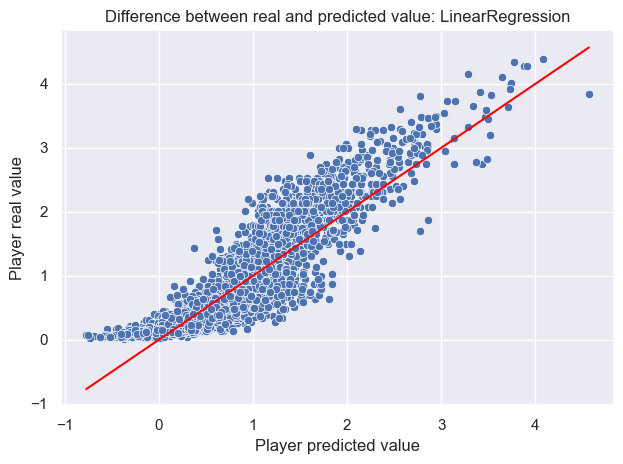

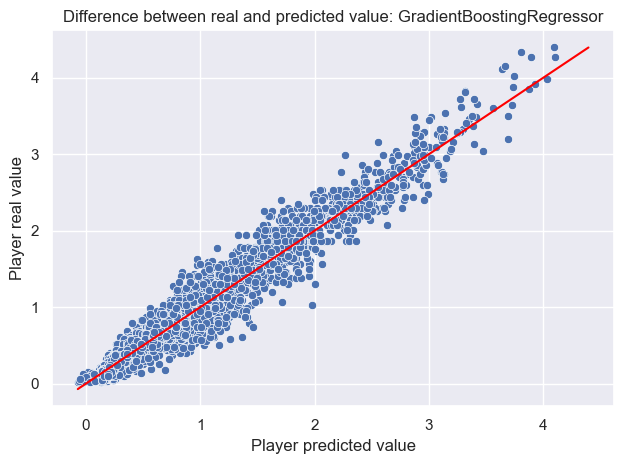

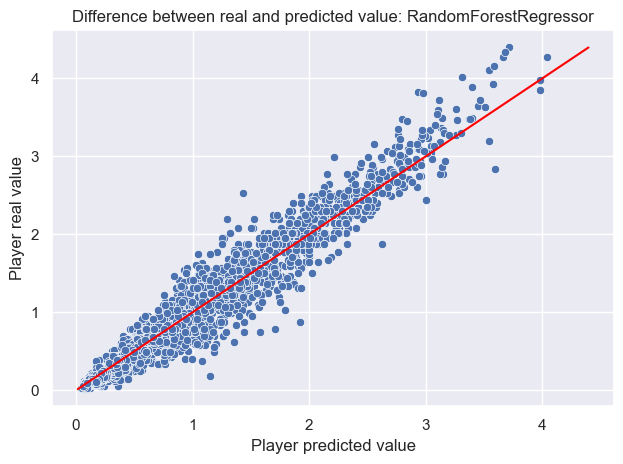

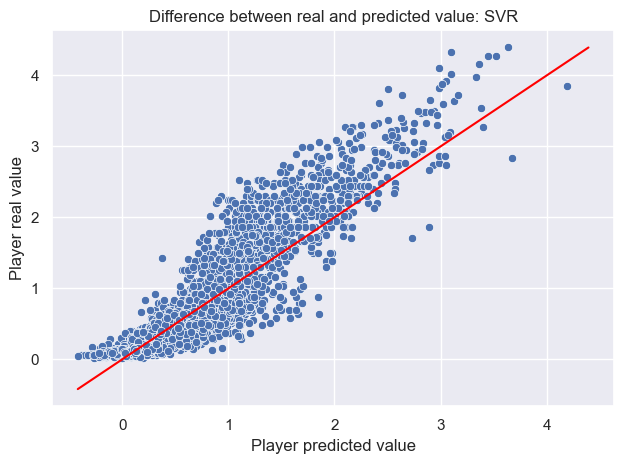

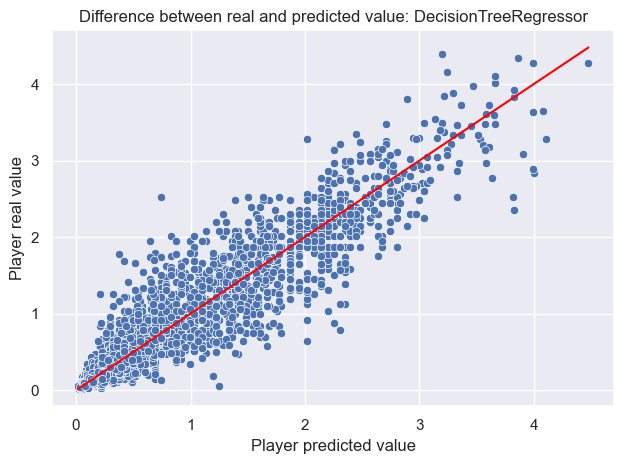

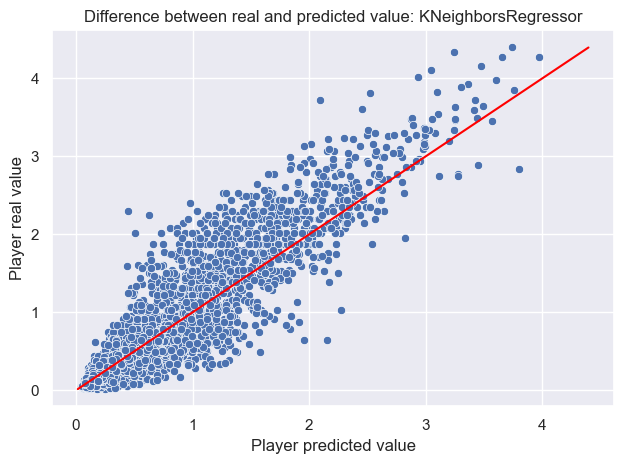

,Model,R2 Train,R2 Test,MSE Train,MSE Test,RMSE Train,RMSE Test,MAE Train,MAE Test
1,GradientBoostingRegressor,0.959649,0.952969,0.021897,0.026741,0.147976,0.163526,0.105064,0.115257
2,RandomForestRegressor,0.992976,0.950590,0.003812,0.028094,0.061739,0.167611,0.039608,0.109289
4,DecisionTreeRegressor,1.000000,0.869830,0.000000,0.074011,0.000000,0.272050,0.000000,0.174060
5,KNeighborsRegressor,0.878961,0.824259,0.065682,0.099922,0.256285,0.316104,0.170825,0.209811
3,SVR,0.809642,0.806879,0.103298,0.109804,0.321400,0.331367,0.225502,0.231447
0,LinearRegression,0.791993,0.792228,0.112876,0.118134,0.335970,0.343706,0.259633,0.265505


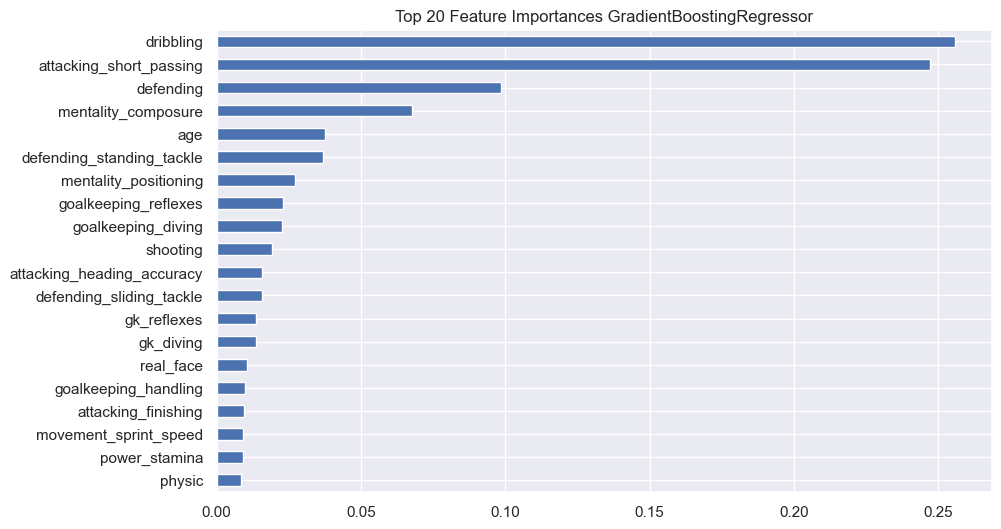

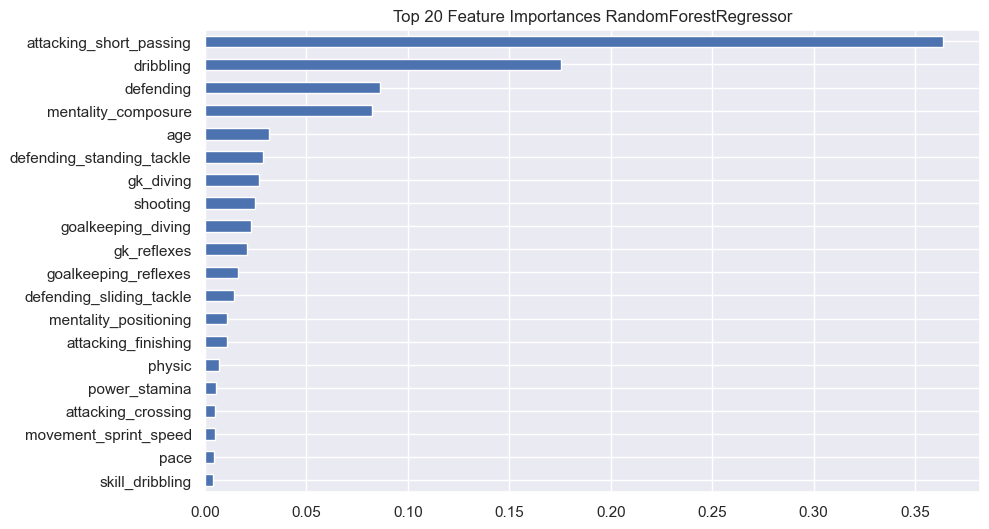

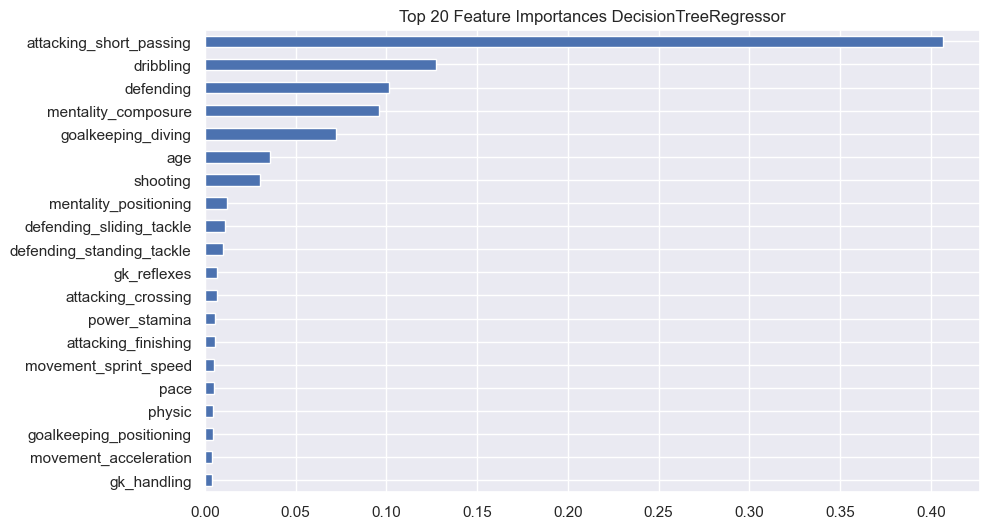

In [234]:
lr = LinearRegression()
gbr = GradientBoostingRegressor()
rf = RandomForestRegressor()
dt = DecisionTreeRegressor()
knn = KNeighborsRegressor()
svr = SVR()
models = [lr,gbr,rf,svr,dt,knn]
models_imp = [gbr, rf, dt]

results = []

for model in models:
    model.fit(x_train, y_train)
    y_pred_test = model.predict(x_test)
    y_pred_train = model.predict(x_train)
    
    r2_train = r2_score(y_train, y_pred_train)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mse_train = mean_squared_error(y_train, y_pred_train)

    r2_test = r2_score(y_test, y_pred_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    mae_test = mean_absolute_error(y_test, y_pred_test)
    mse_test = mean_squared_error(y_test, y_pred_test)
    
    sns.scatterplot(x=y_pred_test, y=y_test, legend=False)
    plt.title(f'Difference between real and predicted value: {model.__class__.__name__}')
    plt.xlabel('Player predicted value')
    plt.ylabel('Player real value')

    min_val = min(min(y_pred_test), min(y_test))
    max_val = max(max(y_pred_test), max(y_test))
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='-', label='y = x')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    results.append({
        "Model": model.__class__.__name__,
        "R2 Train": r2_train,
        "R2 Test": r2_test,
        "MSE Train": mse_train,
        "MSE Test":mse_test,
        "RMSE Train": rmse_train,
        "RMSE Test": rmse_test,
        "MAE Train": mae_train,
        "MAE Test": mae_test,
    })
overral = pd.DataFrame(results)

overral = overral.sort_values(by="R2 Test", ascending=False)
overral = overral.style.background_gradient(cmap="viridis")
display(overral)

for model in models_imp:
    feat_imp = pd.Series(model.feature_importances_, index=original_columns)
    feat_imp.nlargest(20).plot(kind='barh', figsize=(10, 6), title=f'Top 20 Feature Importances {model.__class__.__name__}')
    plt.gca().invert_yaxis()
    plt.show()

